# Workday Scraper - Job Data Analysis

This notebook demonstrates how to load job data from the SQLite database and perform basic data analysis using pandas and matplotlib.

## Setup

First, let's import the necessary libraries and set up our environment.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

import seaborn as sns
import sqlite3
import re
from datetime import datetime
from collections import Counter

# Set up plotting
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Loading Data from the Database

There are two ways to load data from the SQLite database:

1. Using the `export_to_pandas` function from the `workday_scraper.export_utils` module
2. Connecting directly to the database using SQLite and pandas

Let's demonstrate both methods.

### Method 2: Connecting directly to the database

In [35]:
# Connect to the SQLite database
conn = sqlite3.connect("data/workday_jobs.db")

# Query to join jobs and companies tables
query = """
SELECT j.*, c.name as company_name
FROM jobs j
JOIN companies c ON j.company_id = c.id
ORDER BY j.created_at DESC
"""

# Load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Add a 'company' column for consistency
df['company'] = df['company_name']

# Close the connection
conn.close()

# Display the first few rows
df.head()

,id,job_id,title,description,date_posted,employment_type,location,company_id,url,timestamp,created_at,company_name,company
0,517,24WD84445,GeoX Channel Sales Manager,Job Requisition ID # 24WD84445 Position Overvi...,2025-01-17,FULL_TIME,APAC - India - Pune,1,https://autodesk.wd1.myworkdayjobs.com/en-US/E...,2025-03-16T23:56:43.670809,2025-03-16T23:56:43.686102,autodesk,autodesk
1,516,25WD84949,Principal Software Developer,Job Requisition ID # 25WD84949 Position Overvi...,2025-01-17,FULL_TIME,AMER - Canada - British Columbia - Vancouver -...,1,https://autodesk.wd1.myworkdayjobs.com/en-US/E...,2025-03-16T23:56:43.670804,2025-03-16T23:56:43.686008,autodesk,autodesk
2,515,24WD84599,Technical Solutions Executive,Job Requisition ID # 24WD84599 Position Overvi...,2025-01-20,FULL_TIME,APAC - India - Mumbai - The Executive Center,1,https://autodesk.wd1.myworkdayjobs.com/en-US/E...,2025-03-16T23:56:43.670799,2025-03-16T23:56:43.685910,autodesk,autodesk
3,514,24WD84597,Business Development Representative,Job Requisition ID # 24WD84597 Position Overvi...,2025-01-20,FULL_TIME,APAC - India - New Delhi,1,https://autodesk.wd1.myworkdayjobs.com/en-US/E...,2025-03-16T23:56:43.670795,2025-03-16T23:56:43.685798,autodesk,autodesk
4,513,24WD84172,"Senior Director, Experience Design, Platform a...",Job Requisition ID # 24WD84172 French job desc...,2025-02-05,FULL_TIME,AMER - Canada - Ontario - Toronto - University...,1,https://autodesk.wd1.myworkdayjobs.com/en-US/E...,2025-03-16T23:56:43.670791,2025-03-16T23:56:43.685641,autodesk,autodesk


## Data Exploration

Now that we have loaded the data, let's explore it and perform some basic analysis.

In [36]:
# Check the shape of the DataFrame
print(f"Number of job listings: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Display the column names
print("\nColumns:")
print(df.columns.tolist())

Number of job listings: 517
Number of columns: 13

Columns:
['id', 'job_id', 'title', 'description', 'date_posted', 'employment_type', 'location', 'company_id', 'url', 'timestamp', 'created_at', 'company_name', 'company']


In [37]:
# Check for missing values
df.isnull().sum()

id                 0
job_id             0
title              0
description        0
date_posted        0
employment_type    0
location           0
company_id         0
url                0
timestamp          0
created_at         0
company_name       0
company            0
dtype: int64

In [38]:
# Get basic statistics
df.describe(include='all')

,id,job_id,title,description,date_posted,employment_type,location,company_id,url,timestamp,created_at,company_name,company
count,517.000000,517,517,517,517,517,517,517.0,517,517,517,517,517
unique,NaN,517,435,517,97,1,72,NaN,517,517,517,1,1
top,NaN,24WD84445,Senior Software Engineer,Job Requisition ID # 24WD84445 Position Overvi...,2025-02-11,FULL_TIME,APAC - India - Bengaluru - Sunriver,NaN,https://autodesk.wd1.myworkdayjobs.com/en-US/E...,2025-03-16T23:56:43.670809,2025-03-16T23:56:43.686102,autodesk,autodesk
freq,NaN,1,8,1,29,517,81,NaN,1,1,1,517,517
mean,259.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
std,149.389312,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
25%,130.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
50%,259.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
75%,388.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


## Data Analysis

Let's perform some basic analysis on the job data.

### Jobs by Company

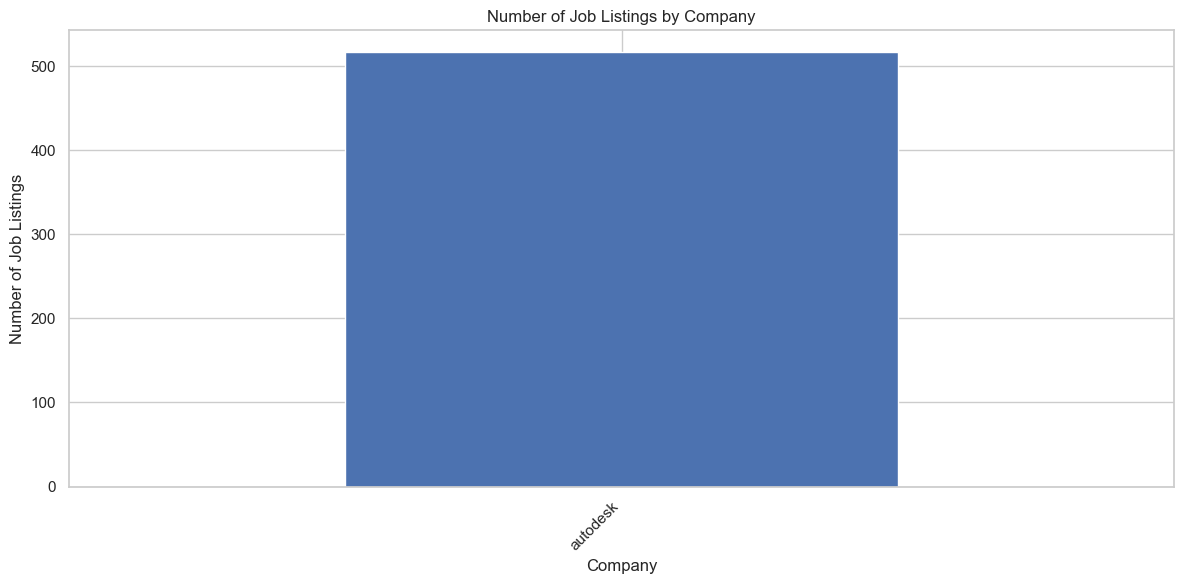

In [39]:
# Count jobs by company
company_counts = df['company'].value_counts()

# Plot the results
plt.figure(figsize=(12, 6))
company_counts.plot(kind='bar')
plt.title('Number of Job Listings by Company')
plt.xlabel('Company')
plt.ylabel('Number of Job Listings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Jobs by Location

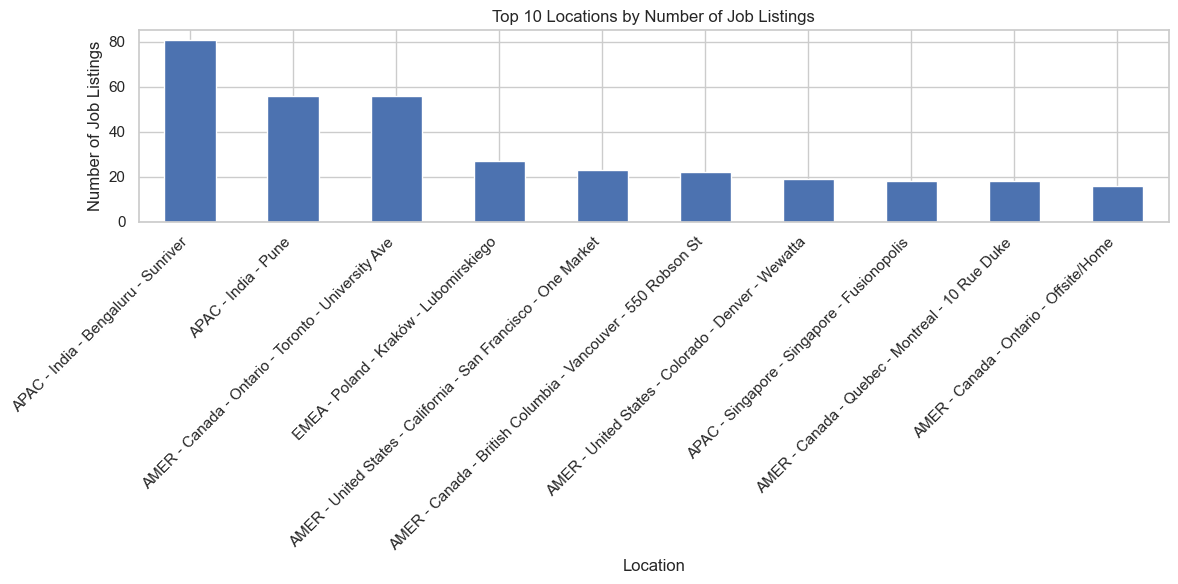

In [40]:
# Count jobs by location
location_counts = df['location'].value_counts().head(10)  # Top 10 locations

# Plot the results
plt.figure(figsize=(12, 6))
location_counts.plot(kind='bar')
plt.title('Top 10 Locations by Number of Job Listings')
plt.xlabel('Location')
plt.ylabel('Number of Job Listings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Location Field Parsing

Let's parse the location field into separate columns (region, country, state, city) for better analysis.

In [41]:
# First, let's examine some examples of the location field
print("Sample location values:")
df['location'].sample(10).tolist()

Sample location values:


['APAC - Korea - Seoul - ASEM Tower',
 'AMER - Canada - Quebec - Montreal - 10 Rue Duke',
 'APAC - India - Bengaluru - Sunriver',
 'AMER - Canada - Ontario - Toronto - University Ave',
 'APAC - India - Bengaluru - Sunriver',
 'APAC - Japan - Tokyo - Toranomon Hills Mori Tower',
 'AMER - Canada - Ontario - Offsite/Home',
 'APAC - India - Pune',
 'AMER - Canada - Ontario - Toronto - University Ave',
 'AMER - United States - California - Offsite/Home']

In [42]:
# Function to parse location into components
def parse_location(location):
    if not isinstance(location, str) or not location.strip():
        return {'region': None, 'country': None, 'state': None, 'city': None}
    
    # Split by delimiter (typically ' - ' or ', ')
    parts = re.split(r'\s*-\s*|\s*,\s*', location)
    parts = [p.strip() for p in parts if p.strip()]
    
    result = {
        'region': None,
        'country': None,
        'state': None,
        'city': None
    }
    
    # Assign parts based on position and length
    if len(parts) >= 4:  # Region - Country - State - City
        result['region'] = parts[0]
        result['country'] = parts[1]
        result['state'] = parts[2]
        result['city'] = parts[3]
    elif len(parts) == 3:  # Country - State - City or Region - Country - State
        # Heuristic: if the third part looks like a city, use Country-State-City pattern
        if any(city_indicator in parts[2].lower() for city_indicator in ['city', 'town', 'village', 'metro']):
            result['country'] = parts[0]
            result['state'] = parts[1]
            result['city'] = parts[2]
        else:  # Assume Region-Country-State pattern
            result['region'] = parts[0]
            result['country'] = parts[1]
            result['state'] = parts[2]
    elif len(parts) == 2:  # Country - State or State - City
        # Heuristic: if the second part is shorter, likely Country-State
        if len(parts[1]) < len(parts[0]):
            result['country'] = parts[0]
            result['state'] = parts[1]
        else:  # Assume State-City
            result['state'] = parts[0]
            result['city'] = parts[1]
    elif len(parts) == 1:  # Just one location component
        # Try to determine if it's a country, state, or city
        # This is a simplistic approach - in a real scenario, you might use a location database
        if parts[0].lower() in ['usa', 'us', 'united states', 'canada', 'uk', 'australia', 'germany', 'france', 'japan', 'china']:
            result['country'] = parts[0]
        else:
            result['state'] = parts[0]  # Default to state if we can't determine
    
    return result

# Apply the function to create new columns
location_components = df['location'].apply(parse_location).apply(pd.Series)
df = pd.concat([df, location_components], axis=1)

# Display the first few rows with the new columns
df[['location', 'region', 'country', 'state', 'city']].head()

,location,region,country,state,city
0,APAC - India - Pune,APAC,India,Pune,None
1,AMER - Canada - British Columbia - Vancouver -...,AMER,Canada,British Columbia,Vancouver
2,APAC - India - Mumbai - The Executive Center,APAC,India,Mumbai,The Executive Center
3,APAC - India - New Delhi,APAC,India,New Delhi,None
4,AMER - Canada - Ontario - Toronto - University...,AMER,Canada,Ontario,Toronto


### Handling Multiple States in the Same Country

Sometimes job listings have multiple states in the same country. Let's identify and handle these cases.

In [43]:
# Function to identify and extract multiple states
def extract_multiple_states(state_field):
    if not isinstance(state_field, str) or not state_field.strip():
        return []
    
    # Common patterns for multiple states
    # 1. Separated by 'or': "CA or NY"
    # 2. Separated by '/': "CA/NY"
    # 3. Separated by '&': "CA & NY"
    # 4. Separated by comma: "CA, NY"
    # 5. Separated by 'and': "CA and NY"
    
    # Replace common separators with a standard one
    standardized = re.sub(r'\s+or\s+|\s*/\s*|\s*&\s*|\s+and\s+', ', ', state_field)
    
    # Split by comma and clean up
    states = [s.strip() for s in standardized.split(',') if s.strip()]
    
    return states

# Apply the function to extract multiple states
df['states_list'] = df['state'].apply(extract_multiple_states)
df['multiple_states'] = df['states_list'].apply(lambda x: len(x) > 1)
df['states_count'] = df['states_list'].apply(len)

# Display jobs with multiple states
multi_state_jobs = df[df['multiple_states']]
print(f"Number of jobs with multiple states: {len(multi_state_jobs)}")
if len(multi_state_jobs) > 0:
    multi_state_jobs[['title', 'company', 'location', 'state', 'states_list']].head()

Number of jobs with multiple states: 21


In [44]:
# Create an exploded view for jobs with multiple states
# This will create a separate row for each state in a multi-state job
if len(multi_state_jobs) > 0:
    exploded_df = df[df['multiple_states']].explode('states_list').copy()
    exploded_df['state'] = exploded_df['states_list']
    print(f"Original multi-state jobs: {len(multi_state_jobs)}")
    print(f"Exploded rows: {len(exploded_df)}")
    exploded_df[['title', 'company', 'location', 'state']].head()

Original multi-state jobs: 21
Exploded rows: 42


### Jobs by Region, Country, and State

Now that we have parsed the location data, let's analyze the distribution of jobs by region, country, and state.

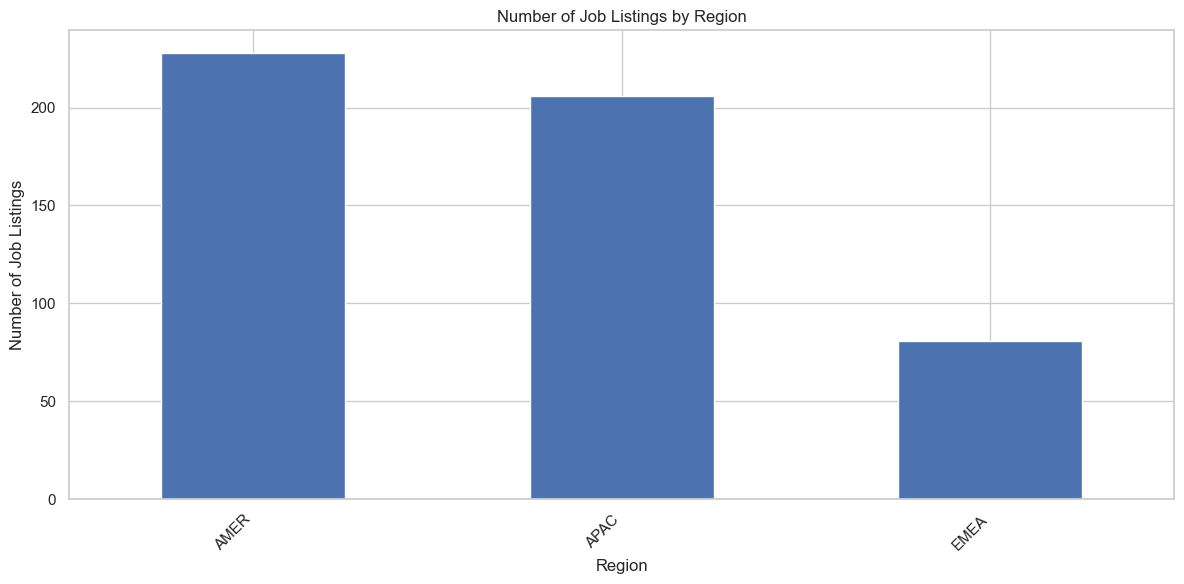

In [45]:
# Jobs by Region
if df['region'].notna().any():
    region_counts = df['region'].value_counts()
    plt.figure(figsize=(12, 6))
    region_counts.plot(kind='bar')
    plt.title('Number of Job Listings by Region')
    plt.xlabel('Region')
    plt.ylabel('Number of Job Listings')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

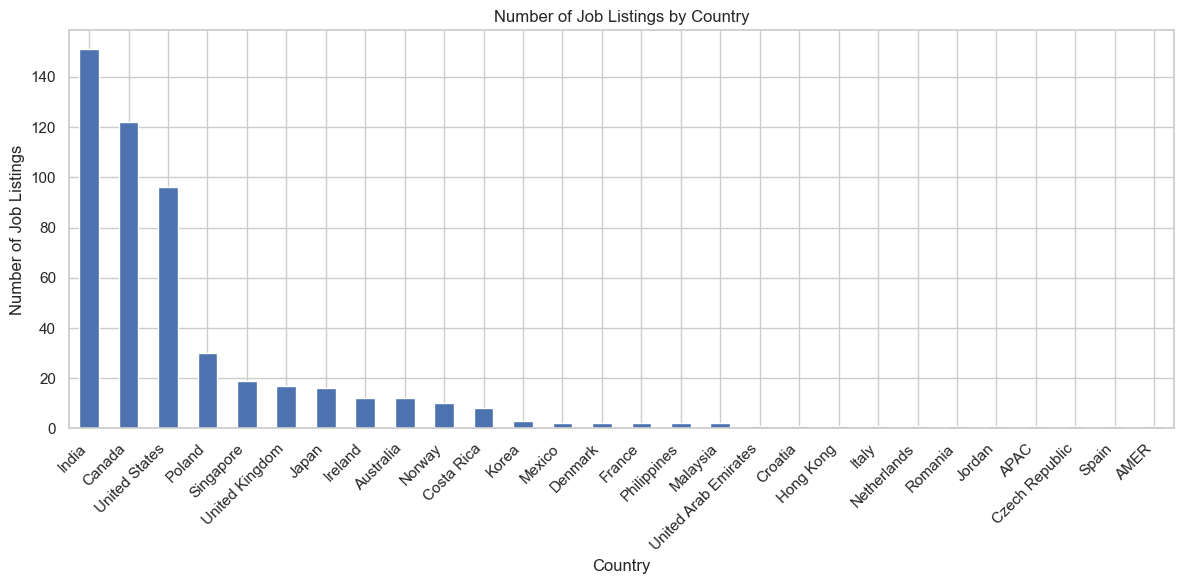

In [46]:
# Jobs by Country
if df['country'].notna().any():
    country_counts = df['country'].value_counts()
    plt.figure(figsize=(12, 6))
    country_counts.plot(kind='bar')
    plt.title('Number of Job Listings by Country')
    plt.xlabel('Country')
    plt.ylabel('Number of Job Listings')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

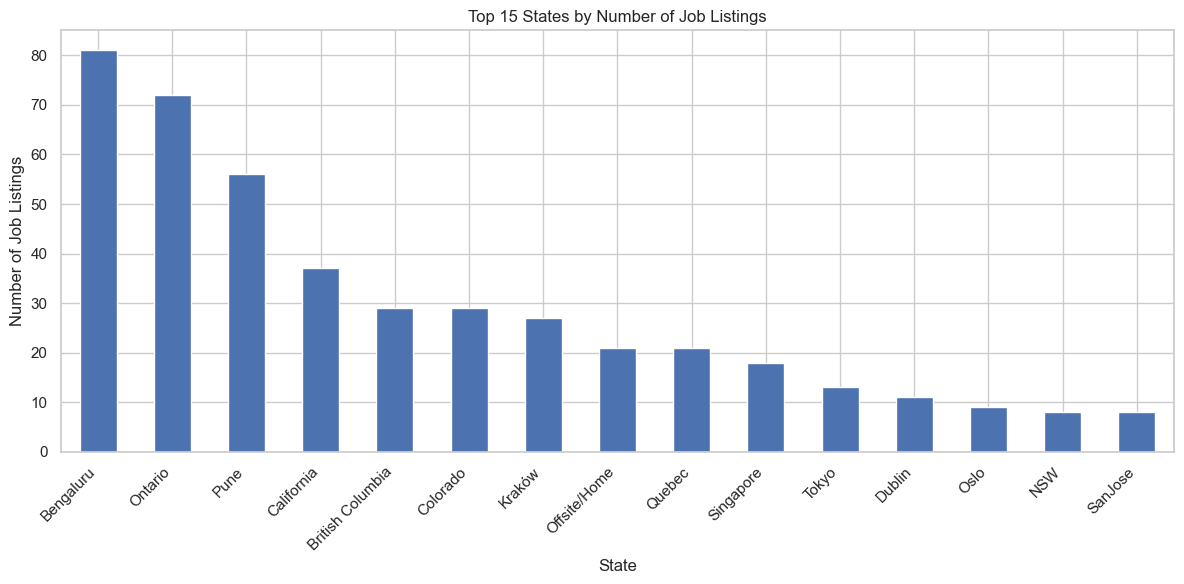

In [47]:
# Jobs by State (Top 15)
if df['state'].notna().any():
    state_counts = df['state'].value_counts().head(15)
    plt.figure(figsize=(12, 6))
    state_counts.plot(kind='bar')
    plt.title('Top 15 States by Number of Job Listings')
    plt.xlabel('State')
    plt.ylabel('Number of Job Listings')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Jobs by Date Posted

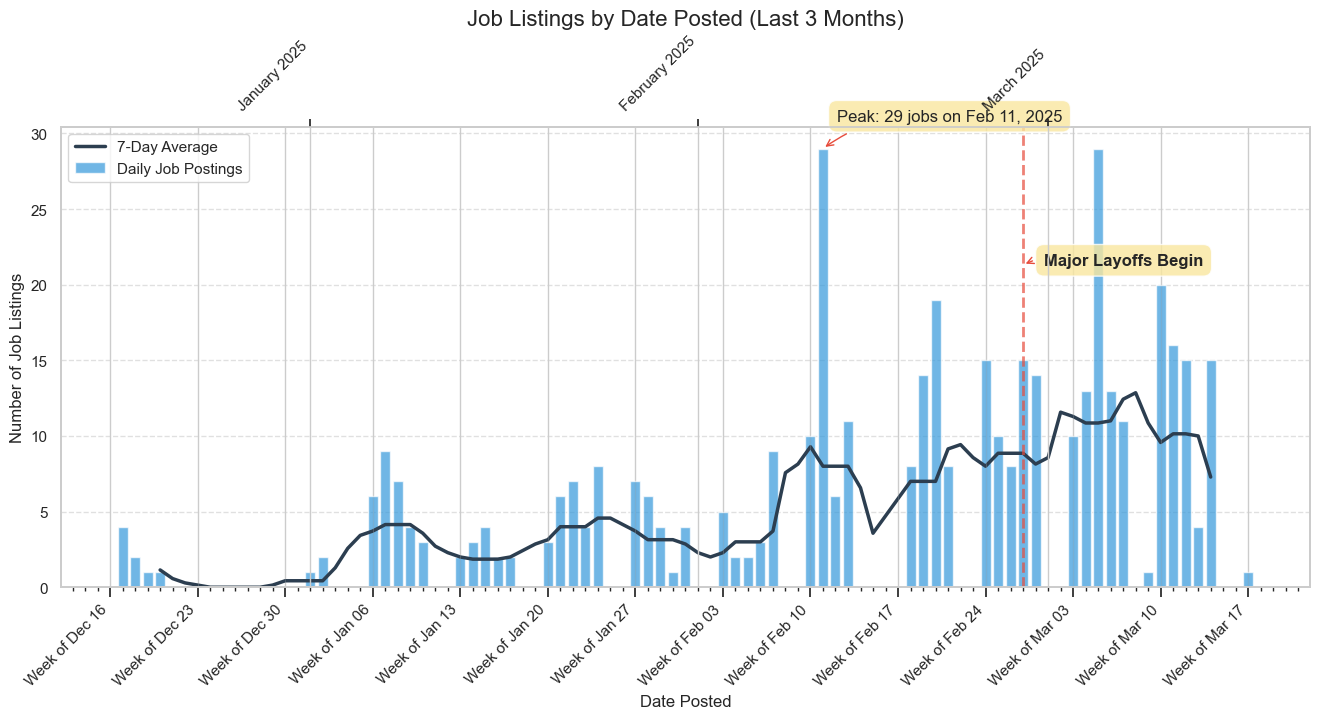

In [48]:
# Jobs by Date Posted with more granular timeline (last 3 months)
# Modified to use bar chart instead of area chart with "week of" labeling

# Import necessary modules
import matplotlib.dates as mdates
from datetime import timedelta, datetime
import numpy as np

# Convert date_posted to datetime
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')

# Extract the date part
df['post_date'] = df['date_posted'].dt.date

# Count jobs by post date
date_counts = df['post_date'].value_counts().sort_index()

# Convert index to datetime for resampling
date_counts.index = pd.to_datetime(date_counts.index)

# Create a date range that covers all dates
date_range = pd.date_range(start=date_counts.index.min(), end=date_counts.index.max())
date_counts = date_counts.reindex(date_range, fill_value=0)

# Calculate the start date for the 3-month window
end_date = date_counts.index.max()
start_date = end_date - pd.DateOffset(months=3)

# Filter data to last 3 months
last_3_months = date_counts[date_counts.index >= start_date]

# Calculate 7-day rolling average for trend line
rolling_avg = last_3_months.rolling(window=7, center=True).mean()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the daily data as bars
ax.bar(last_3_months.index, last_3_months.values, alpha=0.7, color='#3498db', width=0.8, label='Daily Job Postings')

# Plot the rolling average as a darker line
ax.plot(rolling_avg.index, rolling_avg.values, color='#2c3e50', linewidth=2.5, label='7-Day Average')

# Find the date with the maximum job postings in the last 3 months
max_date = last_3_months.idxmax()
max_count = last_3_months.max()

# Format the date for the annotation
formatted_date = max_date.strftime('%b %d, %Y')

# Annotate the maximum point with date included
ax.annotate(f'Peak: {max_count} jobs on {formatted_date}',
            xy=(max_date, max_count),
            xytext=(10, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='#e74c3c'),
            bbox=dict(boxstyle='round,pad=0.5', fc='#f9e79f', alpha=0.8))

# Add vertical line for layoffs on Feb 27, 2025
layoff_date = datetime(2025, 2, 27)
if layoff_date >= start_date and layoff_date <= end_date:  # Check if date is in our window
    # Get the y-value range
    y_min, y_max = ax.get_ylim()
    mid_y = y_max * 0.7  # Position annotation at 70% of the y-axis height
    
    # Add vertical line
    ax.axvline(x=layoff_date, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.7)
    
    # Add annotation for layoffs
    ax.annotate('Major Layoffs Begin',
                xy=(layoff_date, mid_y),
                xytext=(15, 0),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='#e74c3c'),
                bbox=dict(boxstyle='round,pad=0.5', fc='#f9e79f', alpha=0.8),
                fontweight='bold')

# Custom function to format dates as "Week of MMM DD"
def week_of_formatter(x, pos=None):
    date = mdates.num2date(x)
    # Get the Monday of the current week
    monday = date - timedelta(days=date.weekday())
    return f'Week of {monday.strftime("%b %d")}'

# Format the x-axis with "Week of" labels
# Use a custom locator to place ticks at the start of each week
class MondayLocator(mdates.WeekdayLocator):
    def __init__(self):
        super().__init__(byweekday=0)  # Monday = 0

# Set the major tick locator to Mondays and use our custom formatter
ax.xaxis.set_major_locator(MondayLocator())
ax.xaxis.set_major_formatter(plt.FuncFormatter(week_of_formatter))

# Use daily locator for minor ticks
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))  # Show every day as minor tick
ax.tick_params(axis='x', which='minor', length=3, bottom=True)
ax.tick_params(axis='x', which='major', length=7, bottom=True)

# Explicitly set the rotation for x-tick labels
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

# Add monthly labels at the top of the plot for broader context
month_locator = mdates.MonthLocator()
month_formatter = mdates.DateFormatter('%B %Y')
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.xaxis.set_major_locator(month_locator)
ax2.xaxis.set_major_formatter(month_formatter)

# Set rotation for the top x-axis labels
for label in ax2.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

# Add day labels for selected dates (e.g., every Monday) with light vertical lines
for date in last_3_months.index:
    if date.weekday() == 0:  # Monday
        ax.axvline(date, color='#cccccc', linestyle='-', linewidth=0.5, alpha=0.3)

# Add a grid but make it less prominent
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Customize the plot
plt.title('Job Listings by Date Posted (Last 3 Months)', fontsize=16)
ax.set_xlabel('Date Posted', fontsize=12)
ax.set_ylabel('Number of Job Listings', fontsize=12)
ax.legend(loc='upper left')

# Apply tight layout with additional padding to accommodate rotated labels
plt.tight_layout(pad=3.0)

# Show the plot
plt.show()

## Text Analysis

Let's perform some basic text analysis on the job titles and descriptions.

### Most Common Words in Job Descriptions

In [49]:
# Clean and combine all job descriptions
all_descriptions = ' '.join(df['description'].apply(clean_text))

# Count word frequencies
word_counts = Counter(all_descriptions.split())
most_common = word_counts.most_common(20)  # Top 20 words

# Convert to DataFrame for plotting
word_df = pd.DataFrame(most_common, columns=['Word', 'Count'])

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=word_df)
plt.title('Top 20 Words in Job Descriptions')
plt.tight_layout()
plt.show()

NameError: name 'clean_text' is not defined

## Advanced Analysis

Let's perform some more advanced analysis on the job data.

### Jobs by Company and Location

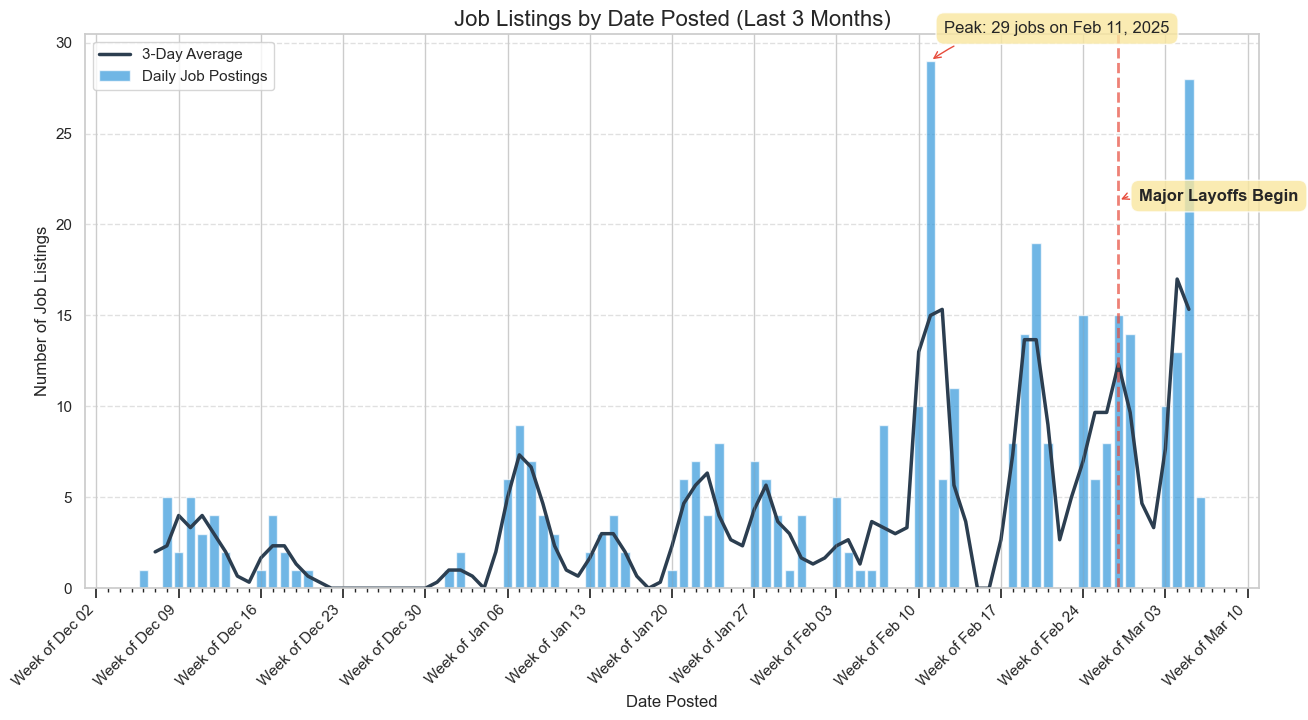

In [ ]:
# Jobs by Date Posted with more granular timeline (last 3 months)
# Modified to use bar chart instead of area chart with "week of" labeling

# Import necessary modules
import matplotlib.dates as mdates
from datetime import timedelta, datetime
import numpy as np

# Convert date_posted to datetime
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')

# Extract the date part
df['post_date'] = df['date_posted'].dt.date

# Count jobs by post date
date_counts = df['post_date'].value_counts().sort_index()

# Convert index to datetime for resampling
date_counts.index = pd.to_datetime(date_counts.index)

# Create a date range that covers all dates
date_range = pd.date_range(start=date_counts.index.min(), end=date_counts.index.max())
date_counts = date_counts.reindex(date_range, fill_value=0)

# Calculate the start date for the 3-month window
end_date = date_counts.index.max()
start_date = end_date - pd.DateOffset(months=3)

# Filter data to last 3 months
last_3_months = date_counts[date_counts.index >= start_date]

# Calculate 7-day rolling average for trend line
rolling_avg = last_3_months.rolling(window=3, center=True).mean()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the daily data as bars
ax.bar(last_3_months.index, last_3_months.values, alpha=0.7, color='#3498db', width=0.8, label='Daily Job Postings')

# Plot the rolling average as a darker line
ax.plot(rolling_avg.index, rolling_avg.values, color='#2c3e50', linewidth=2.5, label='3-Day Average')

# Find the date with the maximum job postings in the last 3 months
max_date = last_3_months.idxmax()
max_count = last_3_months.max()

# Format the date for the annotation
formatted_date = max_date.strftime('%b %d, %Y')

# Annotate the maximum point with date included
ax.annotate(f'Peak: {max_count} jobs on {formatted_date}',
            xy=(max_date, max_count),
            xytext=(10, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='#e74c3c'),
            bbox=dict(boxstyle='round,pad=0.5', fc='#f9e79f', alpha=0.8))

# Add vertical line for layoffs on Feb 27, 2025
layoff_date = datetime(2025, 2, 27)
if layoff_date >= start_date and layoff_date <= end_date:  # Check if date is in our window
    # Get the y-value range
    y_min, y_max = ax.get_ylim()
    mid_y = y_max * 0.7  # Position annotation at 70% of the y-axis height
    
    # Add vertical line
    ax.axvline(x=layoff_date, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.7)
    
    # Add annotation for layoffs
    ax.annotate('Major Layoffs Begin',
                xy=(layoff_date, mid_y),
                xytext=(15, 0),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='#e74c3c'),
                bbox=dict(boxstyle='round,pad=0.5', fc='#f9e79f', alpha=0.8),
                fontweight='bold')

# Custom function to format dates as "Week of MMM DD"
def week_of_formatter(x, pos=None):
    date = mdates.num2date(x)
    # Get the Monday of the current week
    monday = date - timedelta(days=date.weekday())
    return f'Week of {monday.strftime("%b %d")}'

# Format the x-axis with "Week of" labels
# Use a custom locator to place ticks at the start of each week
class MondayLocator(mdates.WeekdayLocator):
    def __init__(self):
        super().__init__(byweekday=0)  # Monday = 0

# Set the major tick locator to Mondays and use our custom formatter
ax.xaxis.set_major_locator(MondayLocator())
ax.xaxis.set_major_formatter(plt.FuncFormatter(week_of_formatter))

# Use daily locator for minor ticks
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))  # Show every day as minor tick
ax.tick_params(axis='x', which='minor', length=3, bottom=True)
ax.tick_params(axis='x', which='major', length=7, bottom=True)

# Explicitly set the rotation for x-tick labels
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

# Add day labels for selected dates (e.g., every Monday) with light vertical lines
for date in last_3_months.index:
    if date.weekday() == 0:  # Monday
        ax.axvline(date, color='#cccccc', linestyle='-', linewidth=0.5, alpha=0.3)

# Add a grid but make it less prominent
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Customize the plot
plt.title('Job Listings by Date Posted (Last 3 Months)', fontsize=16)
ax.set_xlabel('Date Posted', fontsize=12)
ax.set_ylabel('Number of Job Listings', fontsize=12)
ax.legend(loc='upper left')

# Apply tight layout with additional padding to accommodate rotated labels
plt.tight_layout(pad=3.0)

# Show the plot
plt.show()

NameError: name 'mticker' is not defined

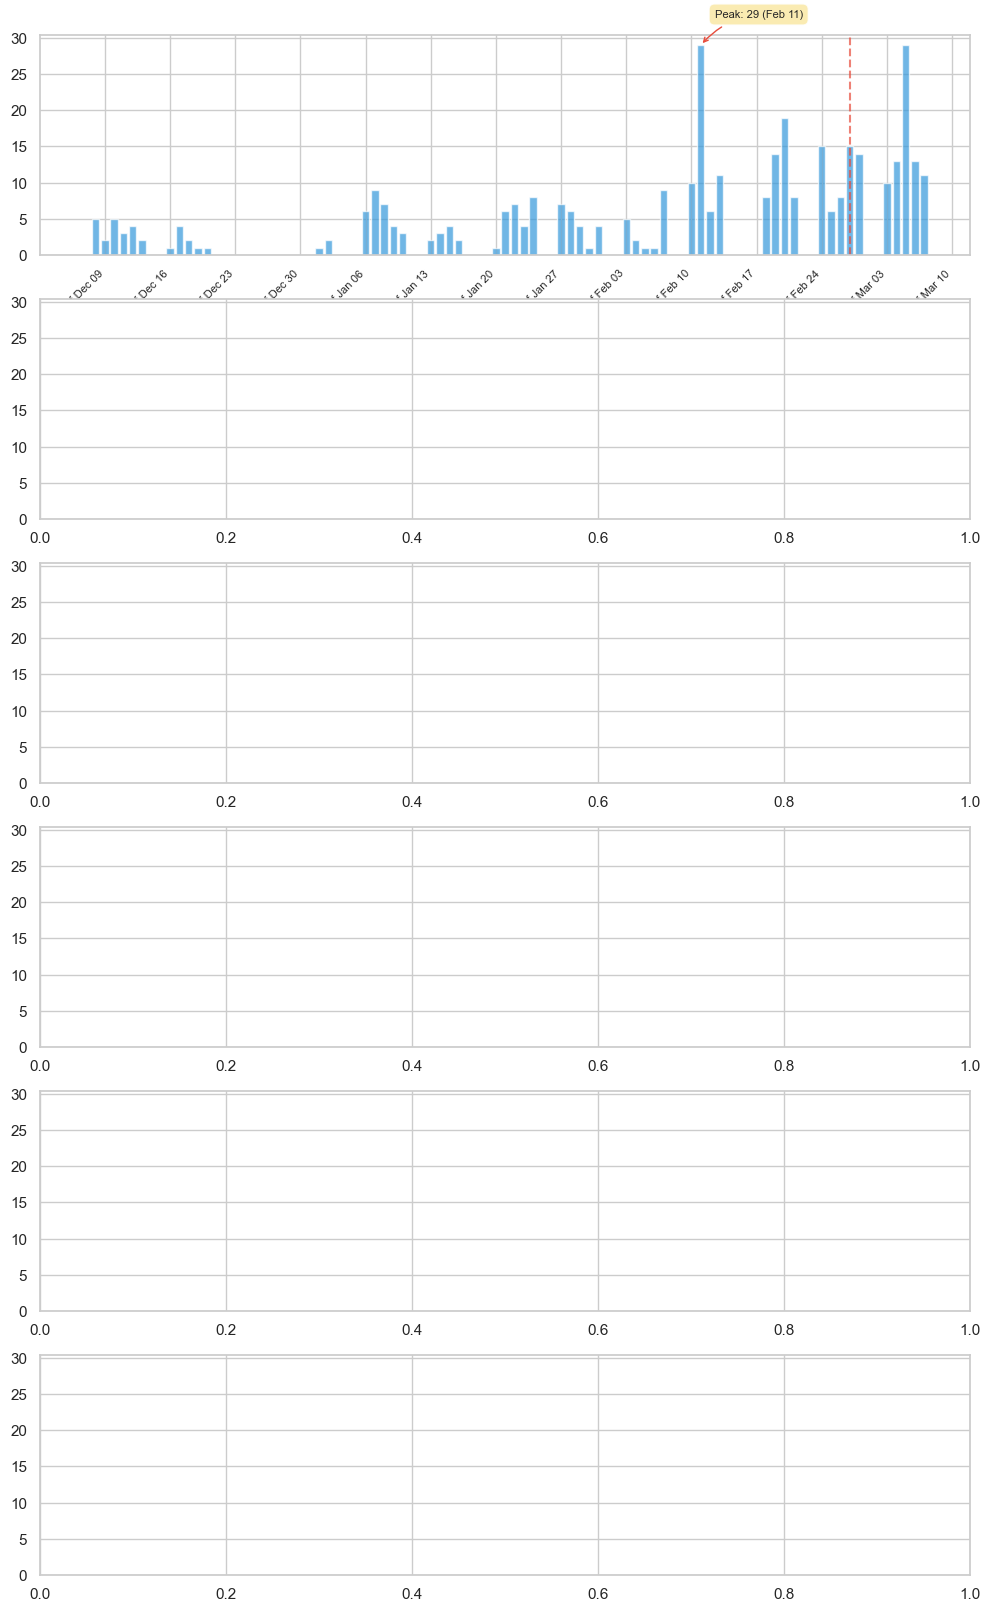

In [ ]:
# Job Listings by Country - Last 3 Months Grid Plot
# Shows trends for top 5 countries with the most job listings

# Import necessary modules
import matplotlib.dates as mdates
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt

# Custom function to format dates as "Week of MMM DD"
def week_of_formatter(x, pos=None):
    date = mdates.num2date(x)
    # Get the Monday of the current week
    monday = date - timedelta(days=date.weekday())
    return f'Week of {monday.strftime("%b %d")}'

# Custom locator to place ticks at the start of each week
class MondayLocator(mdates.WeekdayLocator):
    def __init__(self):
        super().__init__(byweekday=0)  # Monday = 0

# Function to create job trend plot for a specific country
def create_country_job_plot(country_data, ax, country_name, highlight_max=True, y_max=None):
    # Plot the daily data as bars
    ax.bar(country_data.index, country_data.values, alpha=0.7, color='#3498db', width=0.8, label='Daily Job Postings')
    
    # Find and annotate the peak if requested
    if highlight_max and not country_data.empty:
        max_date = country_data.idxmax()
        max_count = country_data.max()
        if max_count > 0:  # Only annotate if there are actually jobs
            formatted_date = max_date.strftime('%b %d')
            xytext_offset = (10, 20) if max_date < country_data.index.max() - pd.Timedelta(days=10) else (-60, 20)
            
            ax.annotate(f'Peak: {max_count} ({formatted_date})',
                        xy=(max_date, max_count),
                        xytext=xytext_offset,
                        textcoords='offset points',
                        fontsize=8,
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='#e74c3c'),
                        bbox=dict(boxstyle='round,pad=0.5', fc='#f9e79f', alpha=0.8))
    
    # Add vertical line for layoffs on Feb 27, 2025
    layoff_date = datetime(2025, 2, 27)
    if layoff_date >= country_data.index.min() and layoff_date <= country_data.index.max():
        ax.axvline(x=layoff_date, color='#e74c3c', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Format the x-axis with "Week of" labels
    ax.xaxis.set_major_locator(MondayLocator())
    ax.xaxis.set_major_formatter(plt.FuncFormatter(week_of_formatter))
    
    # Set rotation for x-tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
        label.set_fontsize(8)
    
    # Add day markers for Mondays with light vertical lines
    for date in country_data.index:
        if date.weekday() == 0:  # Monday
            ax.axvline(date, color='#cccccc', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # **Major gridlines (every 10 units)**
    ax.yaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)  # Keep major grid

    # **Minor gridlines (every 5 units)**
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(5))
    ax.grid(True, axis='y', linestyle=':', alpha=0.4, which='minor')  # Lighter for minor grid

    # Set title and labels
    ax.set_title(f'{country_name}', fontsize=10, fontweight='bold')
    ax.set_ylabel('Job Listings', fontsize=9)
    
    # Set the y-axis limits to be the same for all plots
    if y_max is not None:
        ax.set_ylim(0, y_max)
    
    # Only show legend on the first plot
    if country_name == 'All Countries':
        ax.legend(loc='upper left', fontsize=8)
    
    return ax

# Main code to create the grid of country job trends
# Convert date_posted to datetime and extract date part if not done already
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')
df['post_date'] = df['date_posted'].dt.date

# Identify top 5 countries by job count
top_countries = df['country'].value_counts().head(5).index.tolist()

# Calculate the start date for the 3-month window
end_date = pd.to_datetime(df['post_date'].max())
start_date = end_date - pd.DateOffset(months=3)

# Calculate the maximum value for y-axis to use consistently across all plots
filtered_df = df[df['date_posted'] >= start_date]
all_date_counts = filtered_df['post_date'].value_counts().sort_index()
max_job_count = all_date_counts.max()

# Create country-specific date counts to find global maximum
all_country_max = max_job_count
for country in top_countries:
    country_df = filtered_df[filtered_df['country'] == country]
    country_date_counts = country_df['post_date'].value_counts()
    if len(country_date_counts) > 0:
        country_max = country_date_counts.max()
        all_country_max = max(all_country_max, country_max)

# Add some padding to the max value
y_max = all_country_max * 1.1  # Add 10% padding

# Create a figure with a single column of subplots (one for each country + overall)
fig, axes = plt.subplots(len(top_countries) + 1, 1, figsize=(12, 20), sharex=False, sharey=True)

# Create the overall plot (all countries)
all_date_counts = filtered_df['post_date'].value_counts().sort_index()
all_date_counts.index = pd.to_datetime(all_date_counts.index)
date_range = pd.date_range(start=start_date, end=end_date)
all_date_counts = all_date_counts.reindex(date_range, fill_value=0)

create_country_job_plot(all_date_counts, axes[0], 'All Countries', y_max=y_max)

# Create plots for each of the top 5 countries
for i, country in enumerate(top_countries, 1):
    country_df = df[(df['country'] == country) & (df['date_posted'] >= start_date)]
    country_date_counts = country_df['post_date'].value_counts().sort_index()
    country_date_counts.index = pd.to_datetime(country_date_counts.index)
    country_date_counts = country_date_counts.reindex(date_range, fill_value=0)
    
    create_country_job_plot(country_date_counts, axes[i], country, y_max=y_max)

# Add an overall title
fig.suptitle('Job Listings by Country (Last 3 Months)', fontsize=16, y=0.98)

# Add a common x-axis label at the bottom
fig.text(0.5, 0.04, 'Date Posted', ha='center', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.subplots_adjust(hspace=0.5)  # Increase spacing between plots

# Show the plot
plt.show()